# ETAPAS 


## Etapa 1 - Pré-Processamento dos dados:
1. Após avaliar os dados através da análise exploratória identificamos a necessidade de tratar os dados de tipo *object* e *int*. Os dados do tipo *object* serão tratados através do *OneHotEncoder* para que respondam melhor ao modelo. Já os dados do tipo *int* receberam um tratamento de escala através do *StandardScaler*. 

2. Ambos os processos serão realizados dentro de um **pipeline** para que possamos organizar as etapas de construção do modelo. Um pipeline no scikit-learn é como uma linha de montagem na fábrica, onde você pode encadear várias etapas de processamento de dados e modelagem juntas em uma única sequência. Isso torna mais fácil e eficiente realizar todo o processo, desde o pré-processamento dos dados até a construção do modelo.




In [70]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)


import pandas as pd
import os

os.environ["OMP_NUM_THREADS"] = "1"

DADOS = "../dados/Mall_Customers_no_CustomerID.csv"

df = pd.read_csv(DADOS)
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [71]:
#Criando as etapas de pré-processamento

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

preprocessing = ColumnTransformer(
    [
        ("standard", StandardScaler(), ["Age", "Annual Income (k$)", "Spending Score (1-100)"]),
        ("onehot", OneHotEncoder(), ["Gender"])
    ]
)

preprocessing.fit_transform(df)

df_scaled = pd.DataFrame(
    preprocessing.fit_transform(df),
    columns=preprocessing.get_feature_names_out(),
)

## Etapa 2 - Definição do número de clusters

3. Para definir o número de clusters(5) para utilizar no KMeans utilizei dois métodos diferentes o *Elbow Method* e o *Silhouette Method*. 

- *ElboW Method*: Funciona traçando o número de clusters contra a variabilidade (ou inércia) dentro de cada cluster. O ponto em que a curva começa a se achatar, formando um - "cotovelo", é considerado um indicativo do número ideal de clusters.

- *Silhouette Method*: Ele calcula a "silhueta" de cada ponto de dado, que é uma medida de quão semelhante o ponto é ao seu próprio cluster em comparação com outros clusters.




O número de clusters(k) escolhido foi 5


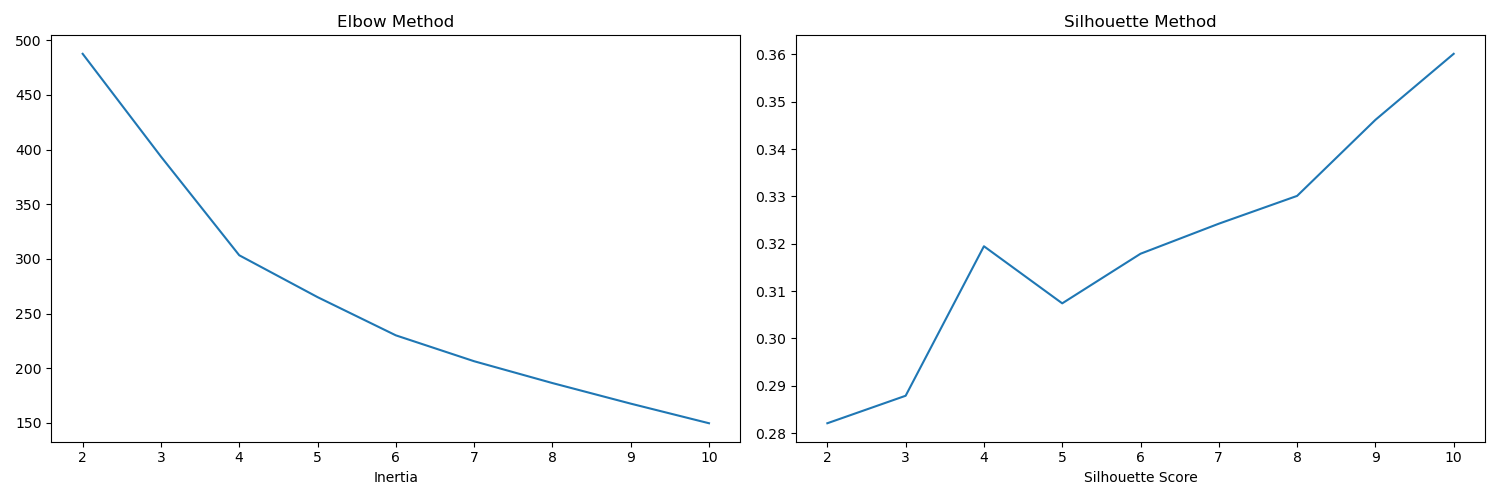

In [72]:
#Utilizando o Elbow Method e o Silhouette Method 
from funcoes_auxiliares import graficos_elbow_silhouette

graficos_elbow_silhouette(df_scaled)

## Etapa 3 - Redução de dimensionalidade e Clusterização:

4. Nessa etapa iremos aplicar o *PCA* para que seja possivel ter uma visualização em 3D dos clusters, ja que usando os dados originais teriamos cinco dimensões. 

- *PCA*: O PCA é uma técnica de redução de dimensionalidade que é comumente usada para identificar padrões nos dados, resumindo as informações contidas em um conjunto de variáveis ​​(ou features) em um conjunto menor de variáveis ​​chamadas componentes principais. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

5. Na etapa de clusterização, empregamos o algoritmo K-Means para identificar padrões nos dados, agrupando-os em clusters. O K-Means utiliza centróides, que são pontos centrais calculados com base na distância entre os pontos de dados. Isso nos permite visualizar graficamente o nível de dispersão dos clientes dentro de seus respectivos grupos, facilitando a compreensão dos padrões de comportamento ou características compartilhadas entre eles. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [73]:
#Incluindo as etapas de clusterização e redução de dimensionalidade no pipeline
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

RANDOM_STATE = 42

pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("pca", PCA(n_components=3, random_state=RANDOM_STATE)),
        ("clustering", KMeans(n_clusters=5, random_state=RANDOM_STATE, n_init=10))
    ]
)

pipeline.fit(df)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('standard', StandardScaler(),
                                                  ['Age', 'Annual Income (k$)',
                                                   'Spending Score (1-100)']),
                                                 ('onehot', OneHotEncoder(),
                                                  ['Gender'])])),
                ('pca', PCA(n_components=3, random_state=42)),
                ('clustering',
                 KMeans(n_clusters=5, n_init=10, random_state=42))])

In [74]:
#Salvando o modelo

import joblib

joblib.dump(pipeline, "../modelos/pipeline_preprocessing_pca_clustering.pkl")

['../modelos/pipeline_preprocessing_pca_clustering.pkl']

## Etapa 4 - Visualização dos resultados:

- Visualização gráfica dos resultados obtidos através do Kmeans após as etapas de pré-processamento e redução de dimensionalidade.

In [75]:
#Visualizando a tabela 

df.head(2)

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81


In [76]:
#Acrescentando ao dataset a coluna com os clusters gerados pelo algoritmo

df_clustered = df.copy()
df_clustered["cluster"] = pipeline["clustering"].labels_

df_clustered.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,Male,19,15,39,1
1,Male,21,15,81,4
2,Female,20,16,6,1
3,Female,23,16,77,4
4,Female,31,17,40,1


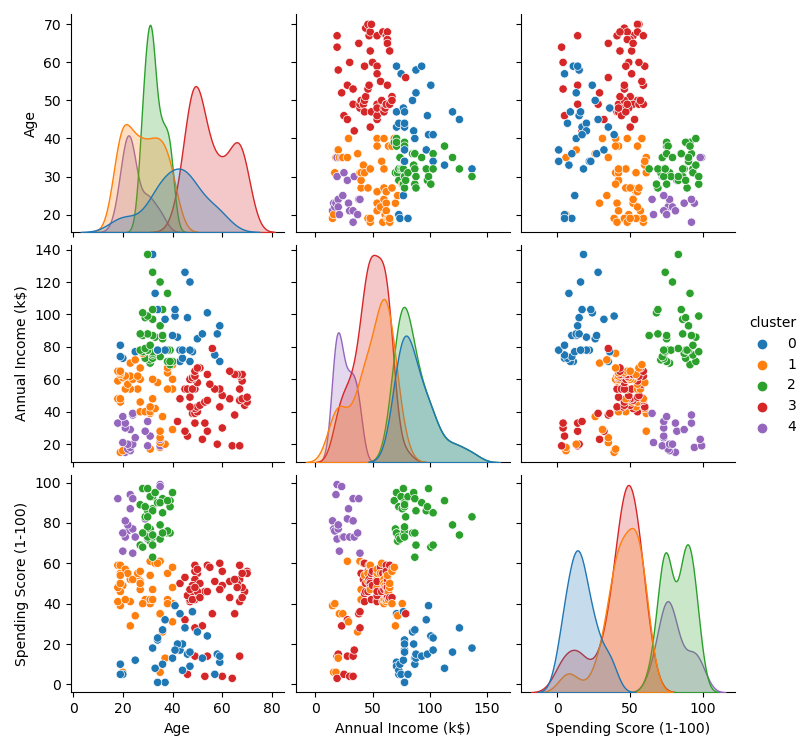

In [77]:
# Opairplot do Seaborn oferece uma visualização abrangente das relações entre as variáveis de um dataset, apresentando uma matriz onde cada célula representa a relação entre duas colunas. 
# Esta matriz possibilita uma análise detalhada das distribuições e das relações entre os diferentes grupos de dados.

import seaborn as sns

sns.pairplot(df_clustered, diag_kind="kde", hue="cluster", palette="tab10");

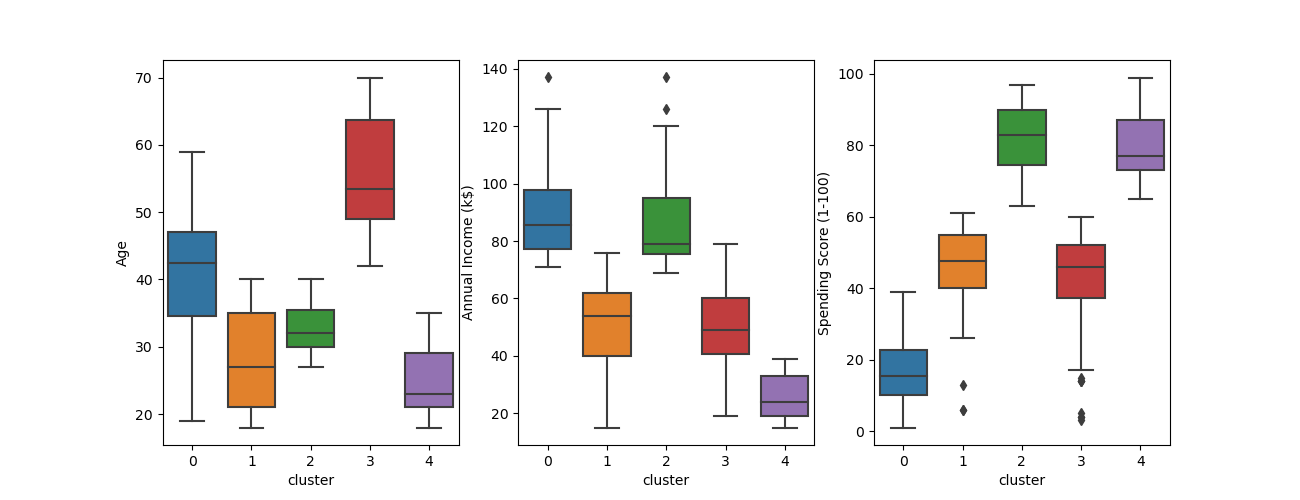

In [78]:
# O boxplot foi escolhido para enxergamos a dispersão dos clusters em cada categoria de forma visual e assim facilitar a construção de personas. 

import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(13, 5))

for ax, col in zip(axs, df_clustered.select_dtypes("number")):
    sns.boxplot(data=df_clustered, x="cluster", y=col, ax=ax)
    
plt.show()

### Clusterização(Agrupamento)

- Cluster 0: Idade intermediária(Adulto) | Salário anual alto | Pontuação baixa

- Cluster 1: Idade intermedária(Jovem Adulto) | Salário anual intermediário | Pontuação intermediária

- Cluster 2: Idade intermedária(Adulto) | Salário anual alto | Pontuação alta

- Cluster 3: Idade avançada(Idoso) | Salário anual intermediário | Pontuação intermediária

- Cluster 4: Idade baixa(Jovem) | Salário anual baixo | Pontuação alta


In [79]:
df_clustered["cluster"].value_counts().sort_index()

cluster
0    34
1    48
2    39
3    58
4    21
Name: count, dtype: int64

In [80]:
df_clustered.groupby(["cluster", "Gender"]).size()

cluster  Gender
0        Female    14
         Male      20
1        Female    31
         Male      17
2        Female    21
         Male      18
3        Female    33
         Male      25
4        Female    13
         Male       8
dtype: int64

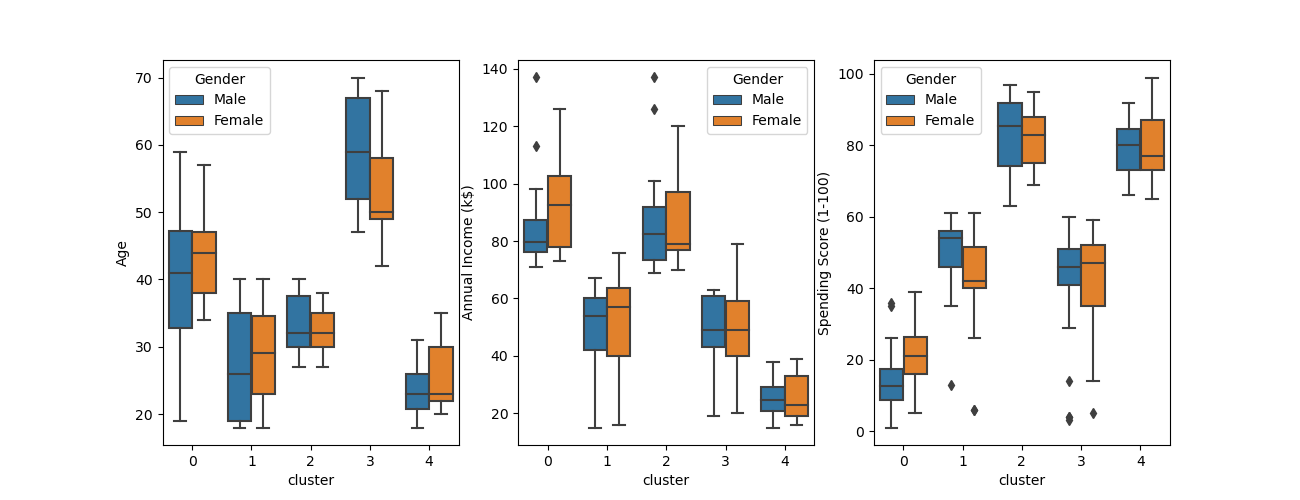

In [81]:
#Tive a ideia de visualizar  os clusters usando o Gênero como parâmetro para enxergar o nivel de influência.

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(13, 5))

for ax, col in zip(axs, df_clustered.select_dtypes("number")):
    sns.boxplot(data=df_clustered, x="cluster", y=col, ax=ax, hue="Gender")
    
plt.show()

## Etapa 4.1 - Construindo o gráfico de visualização 3D. 

In [82]:
pipeline["preprocessing"].get_feature_names_out()

array(['standard__Age', 'standard__Annual Income (k$)',
       'standard__Spending Score (1-100)', 'onehot__Gender_Female',
       'onehot__Gender_Male'], dtype=object)

In [83]:

pipeline["pca"].components_

array([[ 0.70508424, -0.03921531, -0.70473508, -0.04830549,  0.04830549],
       [ 0.02024387,  0.996115  , -0.02730038, -0.05744471,  0.05744471],
       [-0.70661643, -0.00434967, -0.70753413,  0.00590595, -0.00590595]])

In [84]:
pipeline["pca"].get_feature_names_out()

array(['pca0', 'pca1', 'pca2'], dtype=object)

In [85]:
centroids = pipeline["clustering"].cluster_centers_

In [86]:
pipeline[:-1].get_feature_names_out()

array(['pca0', 'pca1', 'pca2'], dtype=object)

In [87]:
pipeline[:-1]

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('standard', StandardScaler(),
                                                  ['Age', 'Annual Income (k$)',
                                                   'Spending Score (1-100)']),
                                                 ('onehot', OneHotEncoder(),
                                                  ['Gender'])])),
                ('pca', PCA(n_components=3, random_state=42))])

In [88]:
# É importante ressaltar que aplicamos a etapa de redução de dimensionalidade para visualizarmos através do gráfico os clusters em 3d, no ínicio tinhamos cinco colunas,
# ou seja, cinco dimensões, após aplicar o PCA reduzimos para três e estamos utilizando elas para construir esse visual abaixo.

df_pca = pd.DataFrame(
    pipeline[:-1].fit_transform(df),
    columns=pipeline[:-1].get_feature_names_out()
)

df_pca.head()

,pca0,pca1,pca2
0,-0.575724,-1.684874,1.315210
1,-1.623595,-1.726481,0.060149
2,0.279614,-1.725314,2.182574
3,-1.511064,-1.796205,0.080242
4,-0.095468,-1.707347,0.690684


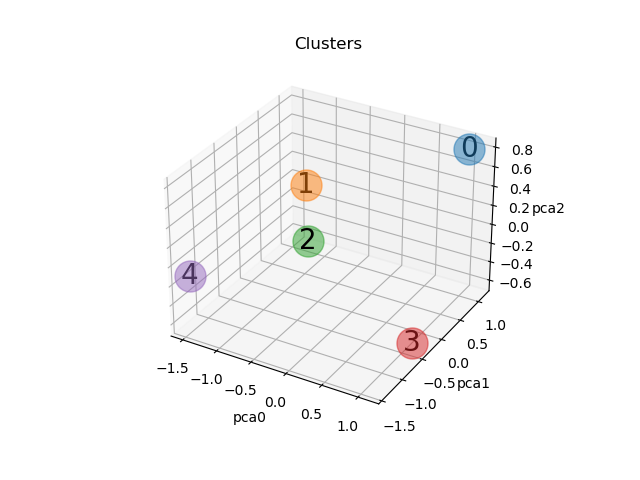

In [89]:
# O 'ipympl' está sendo utilizado para melhorar a experiência da visualização 3d, possibilitando a interação com o gráfico através dos widgets e melhorando sua responsividade.

%matplotlib ipympl  
from funcoes_auxiliares import visualizar_clusters

visualizar_clusters(
    dataframe=df_pca,
    colunas=['pca0', 'pca1', 'pca2'],
    quantidade_cores=5,
    centroids=centroids,
)

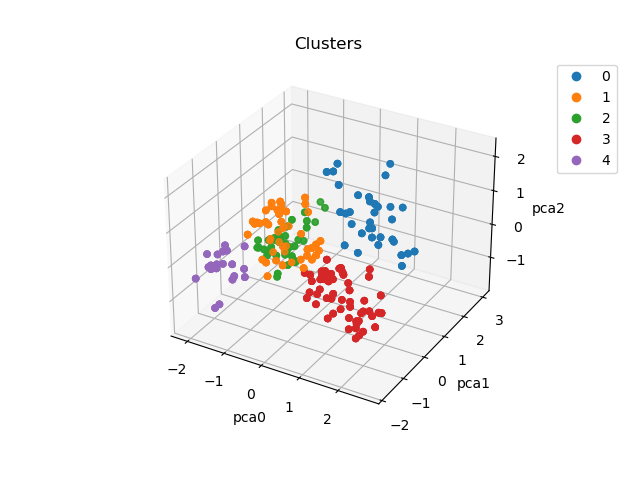

In [90]:
from funcoes_auxiliares import visualizar_clusters

visualizar_clusters(
    dataframe=df_pca,
    colunas=['pca0', 'pca1', 'pca2'],
    quantidade_cores=5,
    centroids=centroids,
    mostrar_pontos=True,
    mostrar_centroids=False,
    coluna_clusters=df_clustered["cluster"]
)

## Conclusão: 

- Durante o projeto passamos pelas seguintes etapas: 
    - <span style="font-size: smaller;">Análise Exploratória utilizando a biblioteca ydata-profiling.</span>
    - <span style="font-size: smaller;">Pré-processamento dos dados utilizando as bibliotecas StandardScaler e OneHotEncoder.</span>
    - <span style="font-size: smaller;">Seleção do Modelo e definição do número de clusters através do Elbow Method e Silhouette Method.</span>
    - <span style="font-size: smaller;">Redução de dimensionalidade utilizando o PCA.</span>
    - <span style="font-size: smaller;">Visualização dos dados utilizando o Matplotib e a biblioteca ipympl para melhorar a experiência de interação com os gráficos.</span>

- Após essas etapas podemos definir as características identificatórias para os clusters gerados conforme tabela abaixo: 

    | Pontuação de Gastos | Salário Anual | Idade         | Class_Idade  |Cluster |
    | --------------------| --------------| --------------| -------------| -------|
    | <span style="font-size: smaller;">Baixa</span> | <span style="font-size: smaller;">Alta</span> | <span style="font-size: smaller;">Intermediária</span> | <span style="font-size: smaller;">Adulto</span> | <span style="font-size: smaller;">0</span> |
    | <span style="font-size: smaller;">Intermediária</span> | <span style="font-size: smaller;">Intermediária</span> | <span style="font-size: smaller;">Intermediária</span> | <span style="font-size: smaller;">Jovem Adulto</span> | <span style="font-size: smaller;">1</span> |
    | <span style="font-size: smaller;">Alta</span> | <span style="font-size: smaller;">Alta</span> | <span style="font-size: smaller;">Intermediária</span> | <span style="font-size: smaller;">Adulto</span> | <span style="font-size: smaller;">2</span> |
    | <span style="font-size: smaller;">Intermediária</span> | <span style="font-size: smaller;">Intermediária</span> | <span style="font-size: smaller;">Avançada</span> | <span style="font-size: smaller;">Idoso</span> | <span style="font-size: smaller;">3</span> |
    | <span style="font-size: smaller;">Alta</span> | <span style="font-size: smaller;">Baixo</span> | <span style="font-size: smaller;">Baixa</span> | <span style="font-size: smaller;">Jovem</span> | <span style="font-size: smaller;">4</span> |
<br>

- Com isso acredito ter atingido o objetivo inicial de **segmentar os clientes** baseado nos dados disponibilizados  para que o supermercado possa aplicar estratégias de negócio de acordo com os perfis. Assim, aumentando a rentabilidade e engajamento. 
